# Housekeeping:

In [2]:
sessionInfo()
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

# The Oregon Health Insurance Experiment

We will work with a data file from an actual scientific publication. They shared key data in various files in the Stata statistical program's main data format. So we'll load that.

`person_id`  is a key for the people in the study.
`treatment` is in the description file, and is random conditional on the `numhh_list` (number of names in lottery)

In 2008, new spots opened for Medicaid, the government health insurance program for the poor, which was previously closed to new enrolment.

We are interested in the effect of health insurance on increased costs and utilization (health would be longer term).

Administrative data is clean, while survey data is not necessarily balanced or representative due to non-response bias.

This data has hospital admissions (by department -- emergency itself is non-significant).

We can also look at number of hostpital days or total list cost.

In [3]:
library(foreign)
descr <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_descriptive_vars.dta")
prgm <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_stateprograms_vars.dta")
s12 <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_survey12m_vars.dta")

Sanity check: see that the identifiers line up across the data sources.

In [4]:
all(s12$person_id == descr$person_id)
all(s12$person_id == prgm$person_id)

[1] TRUE

[1] TRUE

Let's collect some key variables into a new data frame, `P`.

In [5]:
P <- descr[,c("person_id","household_id", "numhh_list")]
P$medicaid <- as.numeric(prgm[,"ohp_all_ever_firstn_30sep2009"]=="Enrolled")
P$selected <- as.numeric(descr[,"treatment"]=="Selected")
levels(P$numhh_list) <- c("1","2","3+")

The 12-month follow-up is the survey that really matters for outcomes that we are collecting into `Y`.

We will need to control for household size interacted with survey return time though.

In [6]:
Y <- s12[,c("weight_12m",
	"doc_any_12m","doc_num_mod_12m",
	"er_any_12m","er_num_mod_12m",
	"hosp_any_12m","hosp_num_mod_12m")]
Y$doc_any_12m <- as.numeric(Y$doc_any_12m=="Yes")
Y$er_any_12m <- as.numeric(Y$er_any_12m=="Yes")
Y$hosp_any_12m <- as.numeric(Y$hosp_any_12m=="Yes")

There are a few covariates that will explain in heterogeneity in responses (or more importantly, treatment effects),or we care about them purely for descriptive purposes. We are collecting these into `X`.

In [7]:
X <- s12[,121:147]
X$dt_returned <- factor(format(s12$dt_returned_12m, "%Y-%m"))

In [8]:
insurv <- which(s12$sample_12m_resp == "12m mail survey responder")
X <- X[insurv,]
Y <- Y[insurv,]
P <- P[insurv,]

In [9]:
sapply(Y,function(y) sum(is.na(y)))
nomiss <- which( !apply(Y,1, function(y) any(is.na(y))) )
X <- X[nomiss,]
Y <- Y[nomiss,]
P <- P[nomiss,]

weight_12m      doc_any_12m  doc_num_mod_12m       er_any_12m 
               0              249              300              227 
  er_num_mod_12m     hosp_any_12m hosp_num_mod_12m 
             260              168              202

Let's pull out the weights

In [10]:
weights <- Y[,1]
Y <- Y[,-1]

Replace some ridiculous values in survey and drop a variable

In [11]:
X$hhsize_12m[X$hhsize_12m>10] <- 10
X$num19_12m <- NULL

Attach `doc_any` to `P` and organize things to make it pretty for text

In [12]:
P$doc_any_12m <- Y$doc_any_12m # you can explore other responses if you want
P <- P[,c(1,2,6,5,4,3)]
names(P)[6] <- "numhh"

## This is where the book starts

A basic comparison of means:

In [13]:
head(P)
nrow(P)
table(P$selected)

,person_id,household_id,doc_any_12m,selected,medicaid,numhh
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,100001,0,1,0,1
2,2,100002,0,1,1,1
5,5,100005,0,1,0,1
6,6,100006,1,1,0,1
8,8,102094,0,0,0,2
9,9,100009,1,0,0,1


[1] 23107


    0     1 
11629 11478 

In ideal circumstances, we get an ATE in two lines:

In [14]:
ybar <- tapply(P$doc_any_12m, P$selected, mean)
( ATE = ybar['1'] - ybar['0'] )

1 
0.05746606

Let's quantify the uncertainty in the estimate:

In [15]:
nsel <- table(P[,c("selected")])
yvar <- tapply(P$doc_any_12m, P$selected, var)
( seATE = sqrt(sum(yvar/nsel)) )

ATE + c(-2,2)*seATE

[1] 0.006428387

[1] 0.04460929 0.07032284

You can also reweight the estimate if you worry about its external validity:

In [16]:
nsel_w <- tapply(weights, P$selected, sum)
ybar_w <- tapply(weights*P$doc_any_12m, P$selected, sum)/nsel_w
( ATEweighted <-  ybar_w['1'] - ybar_w['0'] )

1 
0.05539111

You can repeat the unweighted exercise for other variables, all the way to t-statistics:

In [17]:
ybar <- apply( Y, 2, function(y) tapply(y, P$selected, mean))
nsel <- table(P[,c("selected")])
yvar <- apply( Y, 2, function(y) tapply(y, P$selected, var) )

print( gam <- ybar[2,]-ybar[1,] )

gsd <- sqrt(colSums(yvar/as.numeric(nsel)))
print( gam/gsd )

     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
    0.0574660650     0.2505294032    -0.0025271420    -0.0084462822 
    hosp_any_12m hosp_num_mod_12m 
    0.0005463461     0.0031396190 
     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
       8.9394217        6.6227586       -0.4433509       -0.6715141 
    hosp_any_12m hosp_num_mod_12m 
       0.1646074        0.6042924 


You might worry that the central limit theorem should really work on the level of households, not individuals here, but it doesn't make a difference:

In [18]:
nselhh <- tapply(P$household_id, P$selected, function(h) length(unique(h)))
gsdhh <- sqrt(colSums(yvar/as.numeric(nselhh)))
print( gam/gsdhh )

     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
       8.4143417        6.2280826       -0.4172186       -0.6320600 
    hosp_any_12m hosp_num_mod_12m 
       0.1548938        0.5685051 


But we can worry about the imbalance in `numhh`:

In [19]:
table(P$selected)
table(P[,c("selected","numhh")])


    0     1 
11629 11478 

        numhh
selected    1    2   3+
       0 8684 2939    6
       1 7525 3902   51

So let's build regression models of any outpatient visits.

(The original paper also controls for `dt returned`, but it has no practical effect.)

In [20]:
lin <- glm(doc_any_12m ~ selected + numhh, data=P)
round( summary(lin)$coef["selected",],4) # we should see a 6-7% increase in prob

Estimate Std. Error    t value   Pr(>|t|) 
    0.0639     0.0065     9.9006     0.0000

There is a demeaning-and-interacting way to get the ATE after a covariate adjustment, see equation (5.7)

In [21]:
x <- scale( model.matrix( ~ numhh, data=P)[,-1], scale=FALSE)
colMeans(x)
linadj <- glm(doc_any_12m ~ selected*x, data=P)
summary(linadj)

numhh2       numhh3+ 
-3.723165e-17 -3.149334e-20


Call:
glm(formula = doc_any_12m ~ selected * x, data = P)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6579  -0.5868   0.3421   0.4132   0.8333  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.570410   0.004562 125.040  < 2e-16 ***
selected           0.064230   0.006460   9.943  < 2e-16 ***
xnumhh2           -0.051951   0.010407  -4.992 6.02e-07 ***
xnumhh3+          -0.420160   0.199162  -2.110   0.0349 *  
selected:xnumhh2  -0.025518   0.014173  -1.801   0.0718 .  
selected:xnumhh3+  0.272023   0.210619   1.292   0.1965    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2378277)

    Null deviance: 5536.2  on 23106  degrees of freedom
Residual deviance: 5494.1  on 23101  degrees of freedom
AIC: 32396

Number of Fisher Scoring iterations: 2


Building the household effects is about collapsing the data. The `zebra` index just keeps the first observation of each household (which works just fine for selection and covariates as they vary at that level), while `yhh` is the average outcome per household which we created by collapsing.

In [22]:
yhh <- tapply(P$doc_any_12m, P$household_id, mean)
zebra <- match(names(yhh), P$household_id) # 1st occurence of each HH in P
selectedhh <- P$selected[zebra]
xhh <- x[zebra,]
summary(glm(yhh ~ selectedhh*xhh))


Call:
glm(formula = yhh ~ selectedhh * xhh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6579  -0.5868   0.3421   0.4132   0.4800  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.572661   0.004889 117.133  < 2e-16 ***
selectedhh             0.063291   0.006838   9.255  < 2e-16 ***
xhhnumhh2             -0.043883   0.012183  -3.602 0.000317 ***
xhhnumhh3+            -0.475715   0.273384  -1.740 0.081856 .  
selectedhh:xhhnumhh2  -0.029237   0.016467  -1.775 0.075835 .  
selectedhh:xhhnumhh3+  0.337775   0.289368   1.167 0.243109    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2241384)

    Null deviance: 4620.7  on 20475  degrees of freedom
Residual deviance: 4588.1  on 20470  degrees of freedom
AIC: 27495

Number of Fisher Scoring iterations: 2


If you don't believe the asymptotic theory, you might try a bootstrap. Just make sure to resample households, not individuals.

In [23]:
library(boot)
n <- nrow(P)
hhwho <- split(1:n, P$household_id) # rows grouped by HH
bootfit <- function(hhlist, boothh) {
	bootsamp <- unlist(hhwho[boothh])   # map from HH sample to rows
   	coef(glm(doc_any_12m ~ selected*x, data = P, subset=bootsamp))[2]
}
bs <- boot(names(hhwho), bootfit, 999)
sd(bs$t)
quantile(bs$t, c(.05,.95))

[1] 0.006738917

5%        95% 
0.05274312 0.07487776

Economists also need to know about clustered standard errors:

In [24]:
update.packages()
library('car')

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit




In [25]:
#install.packages('AER')
library(AER)
sqrt(vcovCL(linadj, cluster = P$household_id)[2,2])

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:boot’:

    aml




[1] 0.006589621

### Revisit the same with logistic regressions

In [26]:
lgt <- glm(doc_any_12m ~ selected*numhh, data=P, family="binomial")

In [27]:
predlocs <- data.frame(selected=c(1,1,1,0,0,0), 
	numhh=c('1','2','3+','1','2','3+'))
predy <- predict(lgt, newdata=predlocs, type='response')
( pdiff <- predy[1:3] - predy[4:6] )

1          2          3 
0.07111385 0.04559574 0.34313725

In [28]:
( mu_numhh <- table(P$numhh)/nrow(P) )
pdiff%*%mu_numhh


          1           2          3+ 
0.701475743 0.296057472 0.002466785 

0.06423005


Bootstrap it:

In [29]:
bootfit_lgt <- function(hhlist, boothh) {
	bootsamp <- unlist(hhwho[boothh])   # map from HH sample to rows
   	lgt <- glm(doc_any_12m ~ selected*numhh, data = P, subset=bootsamp, family="binomial")
   	predy <- predict(lgt, newdata=predlocs, type='response')
	mu_numhh%*%(predy[1:3] - predy[4:6])
}
bslgt <- boot(names(hhwho), bootfit_lgt, 99)
sd(bslgt$t)
quantile(bslgt$t, c(.05,.95))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 0.007261148

5%        95% 
0.05375413 0.07528320

## Finally, jump to the back of the chapter for some two-stage least squares (Instrumental Variables) on this data

In [30]:
stage1 <- lm( medicaid ~ selected + numhh, data=P)
phat <- predict(stage1, newdata=P)
stage2 <- lm( doc_any_12m ~ phat + numhh, data=P, x=TRUE)
coef(stage2)

(Intercept)        phat      numhh2     numhh3+ 
 0.55883837  0.21259703 -0.05302372 -0.14483052

However, the standard errors are not this easy:

In [31]:
library(Matrix)
resids <- P$doc_any_12m - predict( stage2, 
	newdata=data.frame(numhh=P$numhh, phat=P$medicaid))
meat <- Diagonal(x=resids^2)
bread <- stage2$x%*%solve(t(stage2$x)%*%stage2$x)
sandwich <- t(bread)%*%meat%*%bread
print( segam <- sqrt(sandwich[2,2]) )

[1] 0.02112282


So you can get a confidence interval from this --- or just use built-in packages from economists (for very similar standard errors, at least here)

In [32]:
coef(stage2)["phat"] + c(-2,2)*segam

[1] 0.1703514 0.2548427

In [33]:
library(AER)
aeriv <- ivreg( doc_any_12m  ~ medicaid + numhh | selected + numhh, data=P)

summary(aeriv)


Call:
ivreg(formula = doc_any_12m ~ medicaid + numhh | selected + numhh, 
    data = P)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7714 -0.5588  0.2286  0.4412  0.5860 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.558838   0.007147  78.191  < 2e-16 ***
medicaid     0.212597   0.021153  10.050  < 2e-16 ***
numhh2      -0.053024   0.006952  -7.627 2.49e-14 ***
numhh3+     -0.144831   0.063747  -2.272   0.0231 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4804 on 23103 degrees of freedom
Multiple R-Squared: 0.03678,	Adjusted R-squared: 0.03665 
Wald test: 59.18 on 3 and 23103 DF,  p-value: < 2.2e-16 


In [34]:
sqrt( (solve(t(stage2$x)%*%stage2$x)*var(resids))[2,2] )

[1] 0.02115164

In [35]:
sqrt(vcovHC(aeriv)[2,2])

[1] 0.02112588

In [36]:
segam

[1] 0.02112282

In [37]:
sqrt(vcovCL(aeriv, cluster = P$household_id)[2,2])

[1] 0.02163934

# Difference-in-differences

Load the paid search data:

In [38]:
sem <- read.csv("paidsearch.csv")
sem$dma <- factor(sem$dma)

Quick summary: total revenue by date and treatment/controls

In [39]:
totalrev <- tapply(sem$revenue, sem[,c("date","search.stays.on")], sum)

For plotting, we'll convert the row `dates` to R Date class

In [40]:
asdate <- as.Date(rownames(totalrev), format="%d-%b-%y")

Order everything by date

In [41]:
totalrev <- totalrev[order(asdate),]
asdate <- sort(asdate)

Now plot the revenues by group

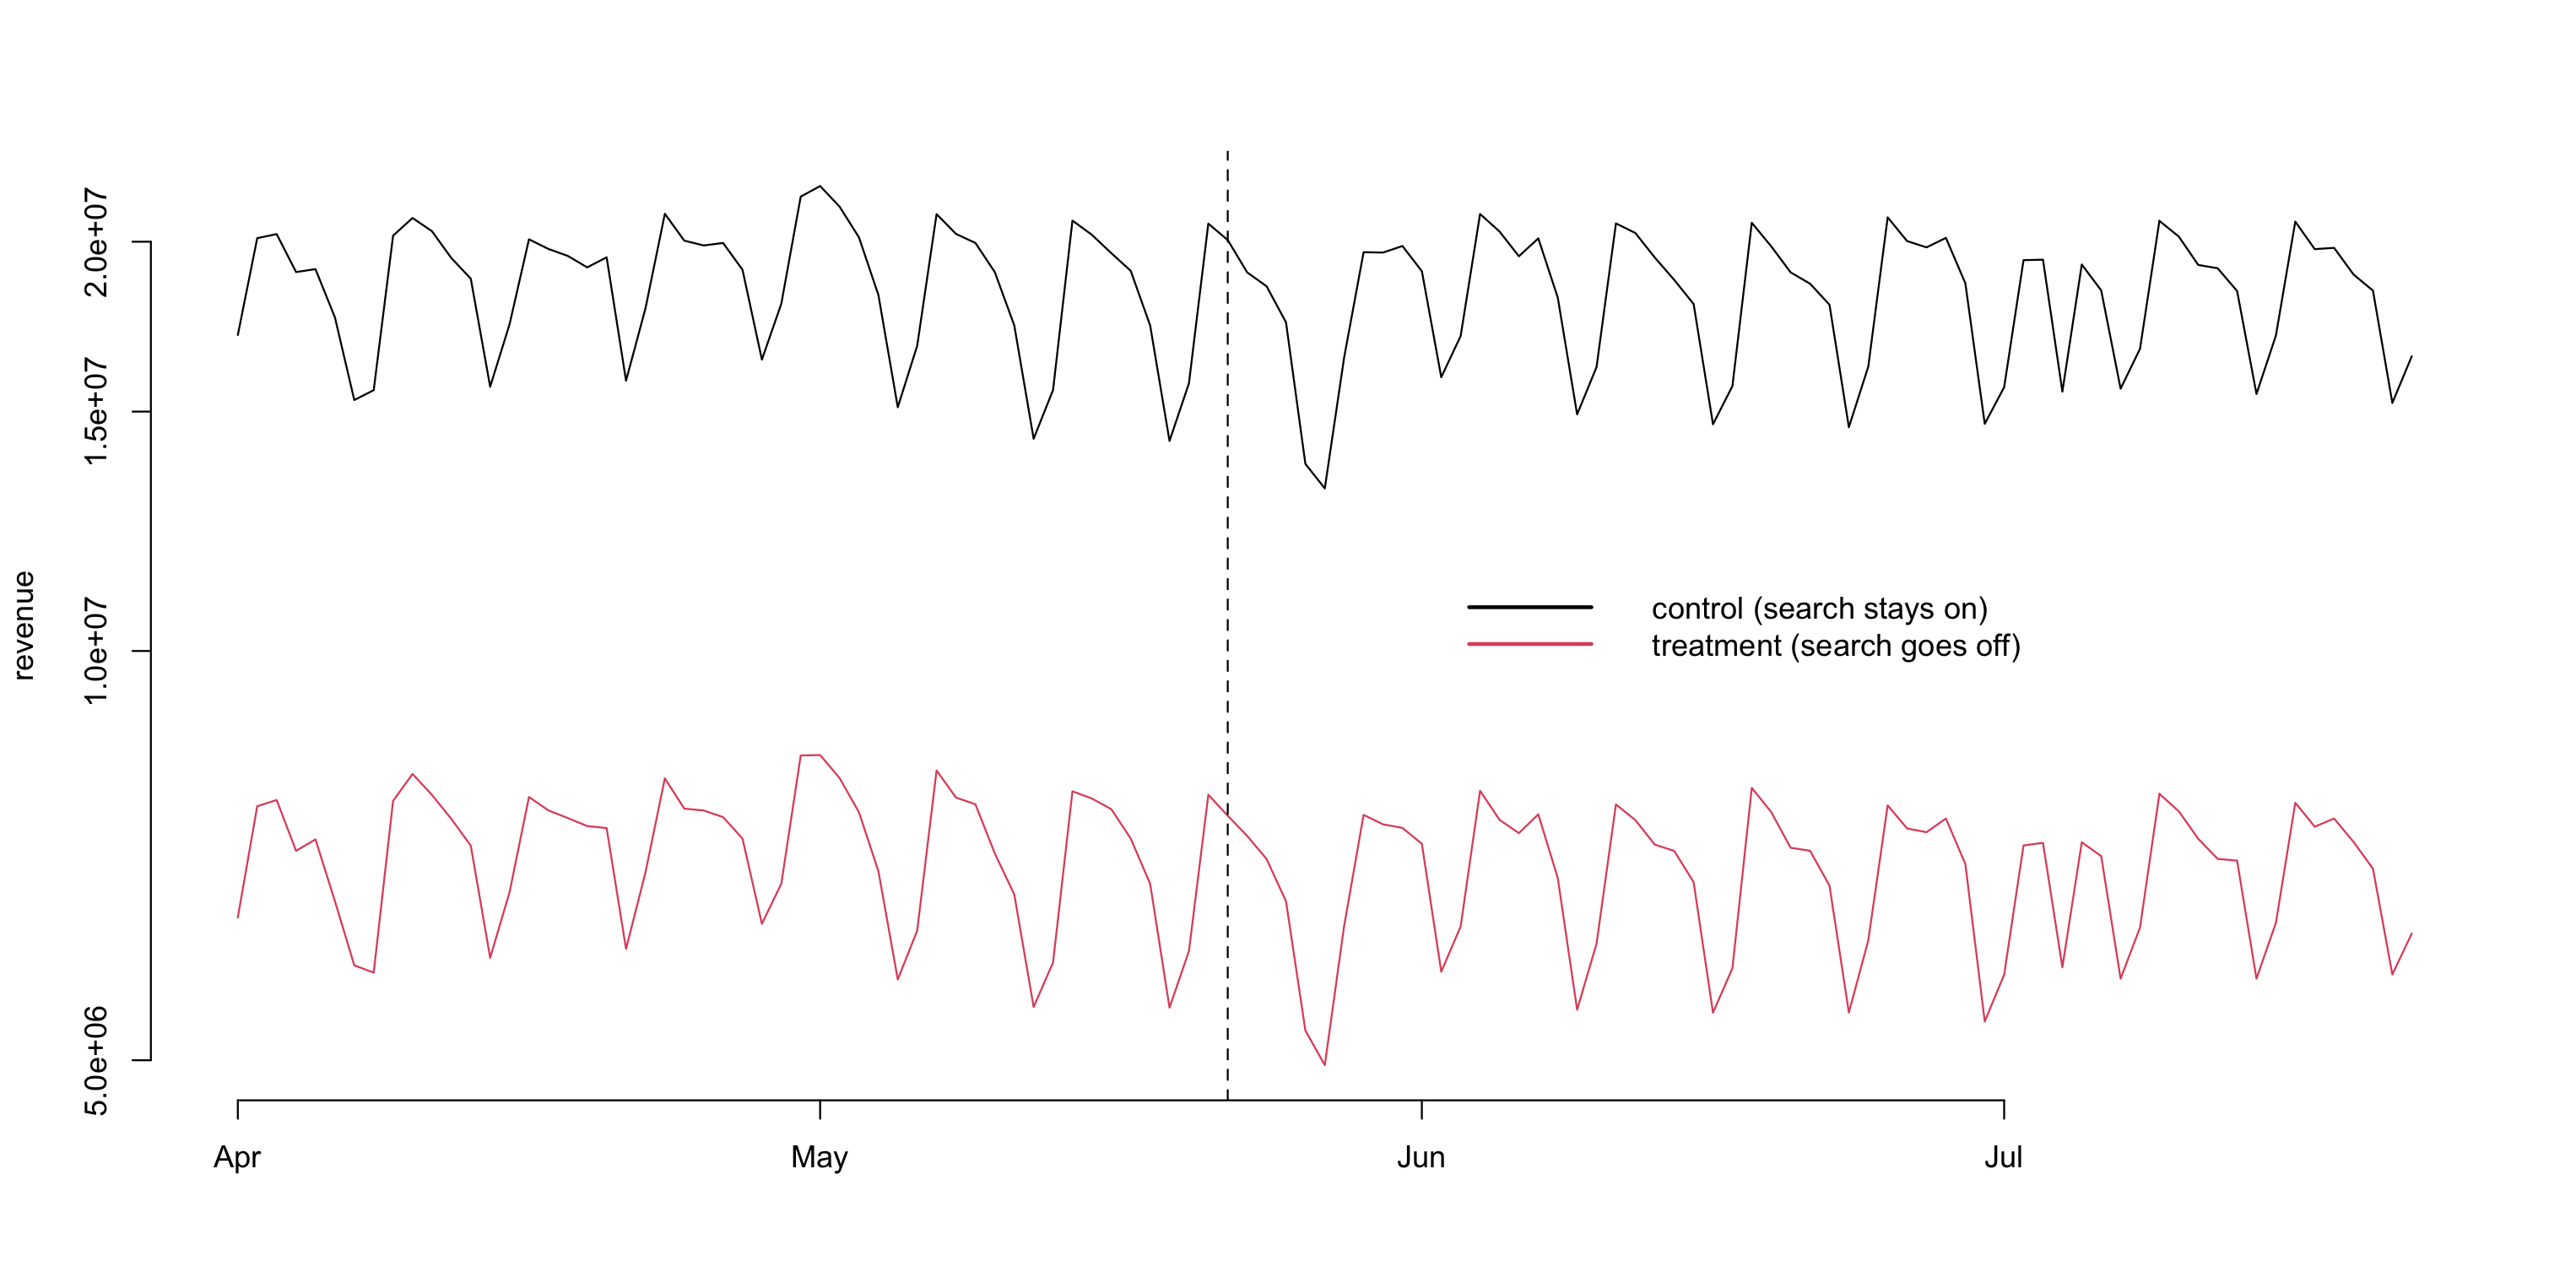

In [42]:
plot(asdate, totalrev[,'0'], type="l", bty="n", col=2,
	ylim=range(totalrev), log="y", xlab="", ylab="revenue")
lines(asdate, totalrev[,'1'], type="l")
legend("right",col=c(1,2), lwd=2, bty="n",
	legend=c("control (search stays on)", "treatment (search goes off)"))
abline(v=as.Date("2012-05-22"), lty=2)

As well as the difference between groups

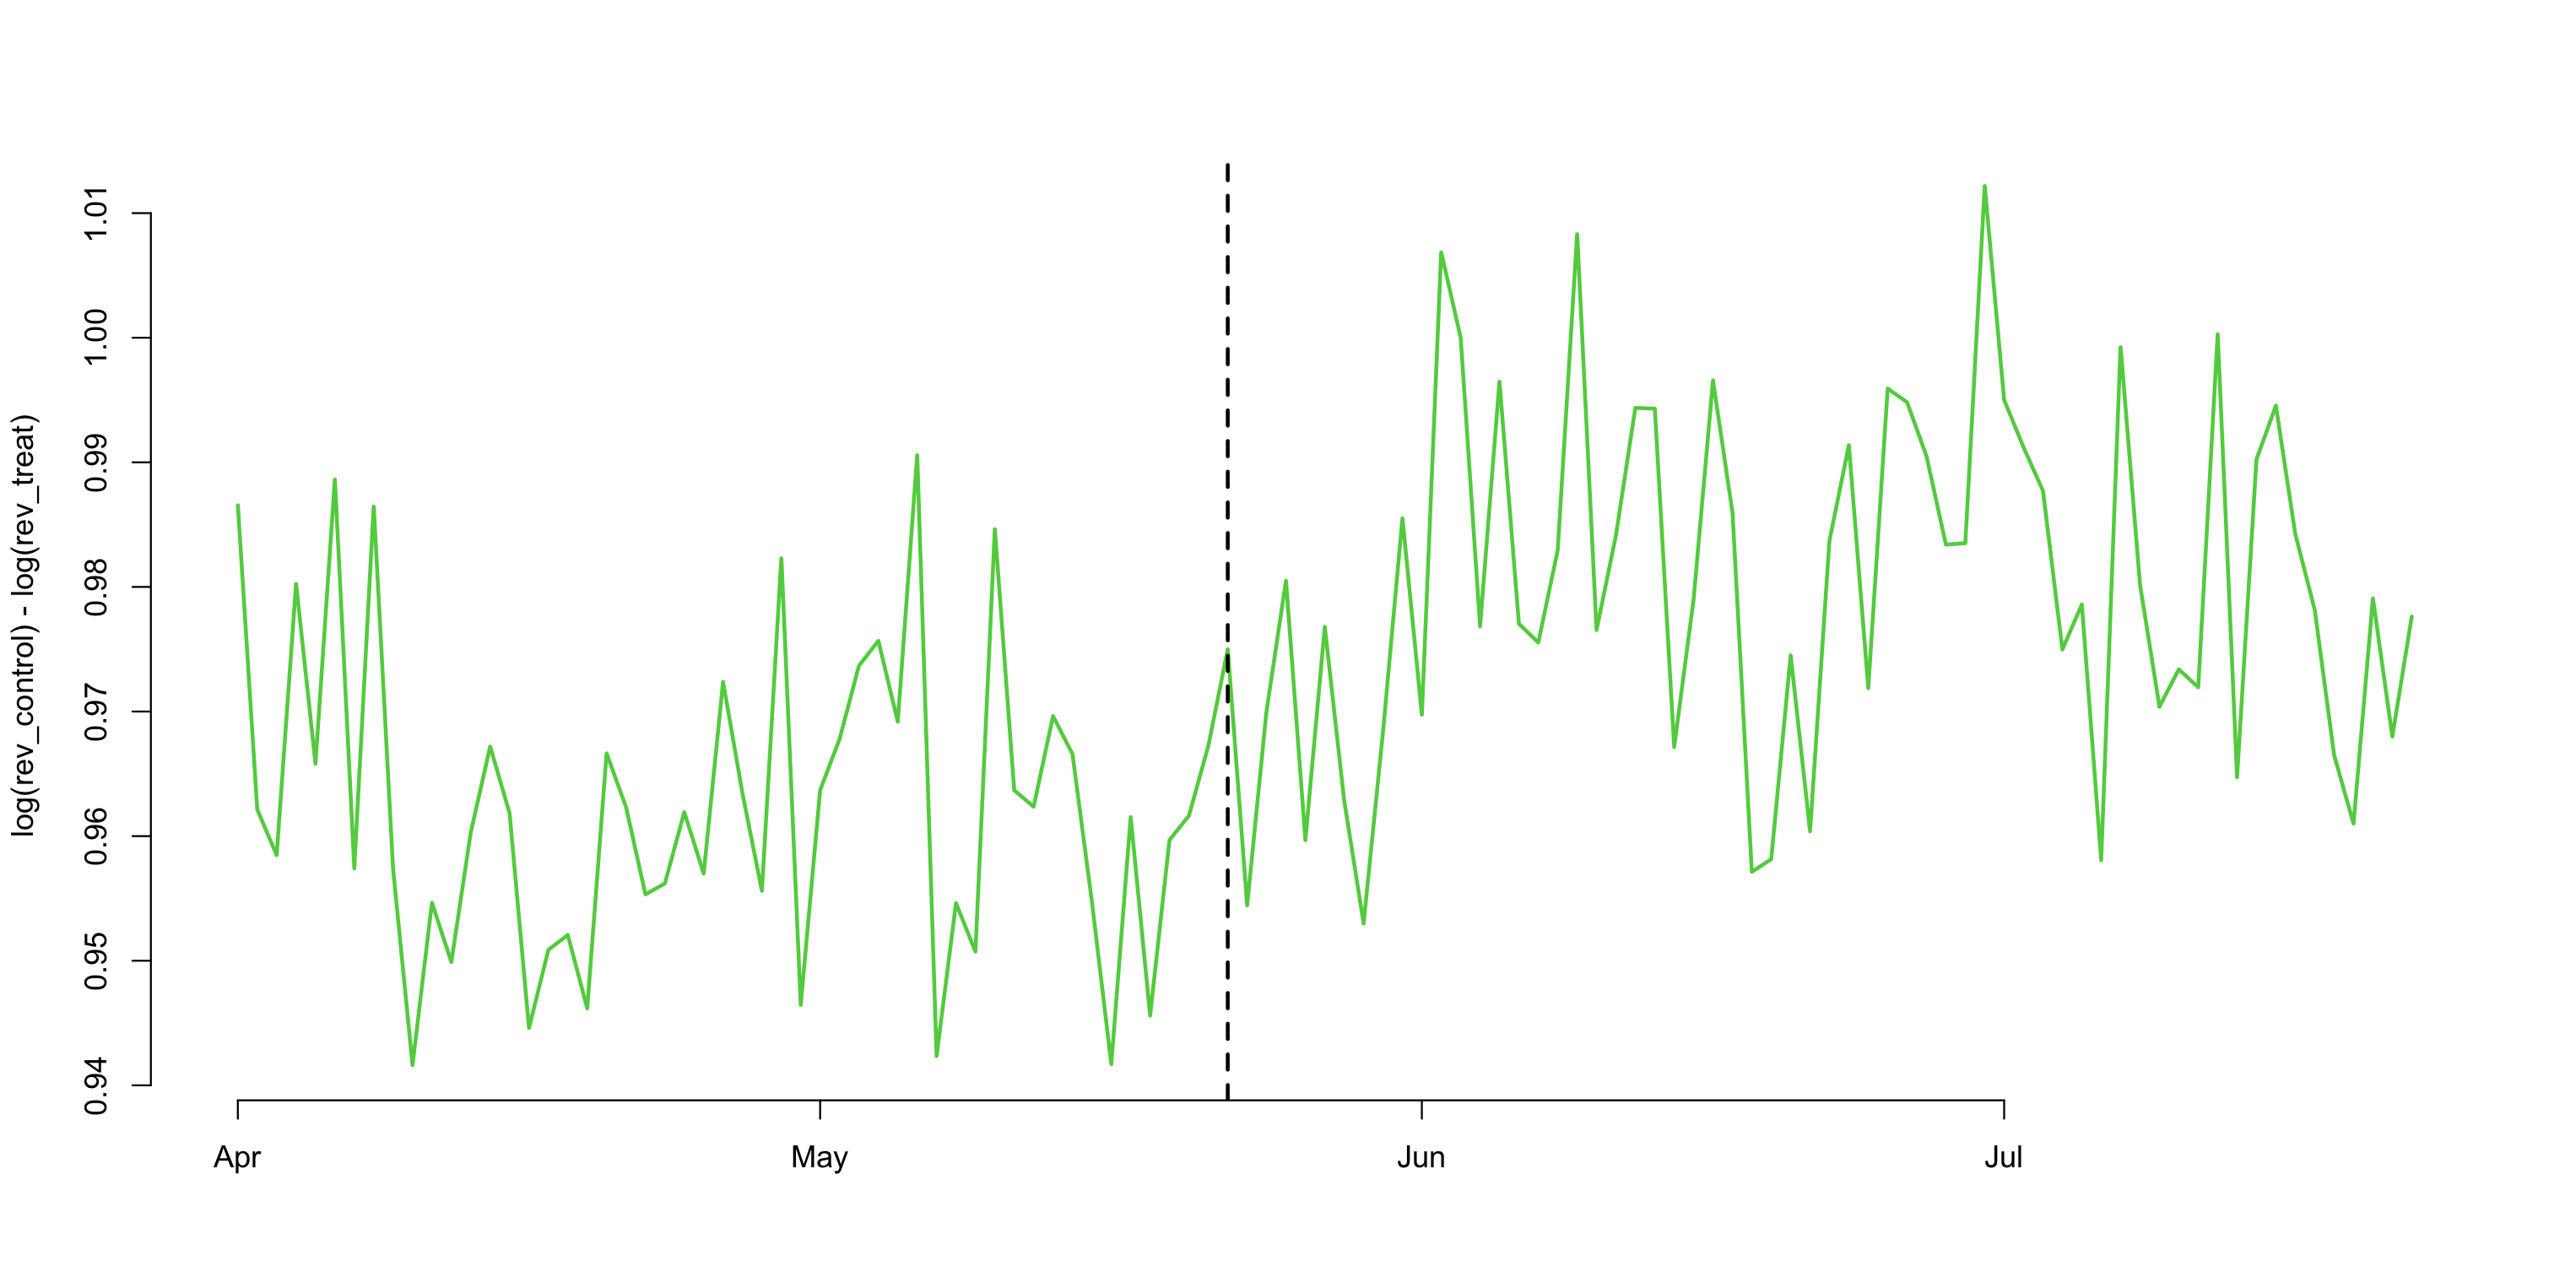

In [43]:
plot(asdate, log(totalrev[,'1'])-log(totalrev[,'0']), 
	type="l", bty="n", col=3,lwd=2, xlab="", 
	ylab="log(rev_control) - log(rev_treat)")
abline(v=as.Date("2012-05-22"), lty=2,lwd=2)

Now let's do some analysis.
(We'll also make use of the `data.table` package.)

In [44]:
library(data.table)
sem <- as.data.table(sem)
semavg <- sem[, 
			list(d=mean(1-search.stays.on), y=mean(log(revenue))), 
			by=c("dma","treatment_period")]
setnames(semavg, "treatment_period", "t")
semavg <- as.data.frame(semavg)

Focus on the interaction term (and its clustered standard errors)

In [45]:
library(AER)
semreg <- glm(y ~ d*t, data=semavg)
summary(semreg)
sqrt(vcovCL(semreg, cluster=semavg$dma)['d:t','d:t'])


Call:
glm(formula = y ~ d * t, data = semavg)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8518  -0.7061  -0.0447   0.7696   3.6521  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.948646   0.100495 108.948   <2e-16 ***
d            0.014081   0.176603   0.080    0.936    
t           -0.039400   0.142121  -0.277    0.782    
d:t         -0.006587   0.249754  -0.026    0.979    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1.434083)

    Null deviance: 596.77  on 419  degrees of freedom
Residual deviance: 596.58  on 416  degrees of freedom
AIC: 1349.3

Number of Fisher Scoring iterations: 2


[1] 0.005534297

In [46]:
head(semavg)

,dma,t,d,y
,<fct>,<int>,<dbl>,<dbl>
1,500,0,1,11.22800
2,501,0,0,14.58000
3,502,0,0,10.38516
4,503,0,0,10.48166
5,504,0,0,13.39498
6,505,0,1,12.81640


You can use DMA fixed effects insted of clustering:

In [47]:
dmareg <- glm(y ~ dma + d*t, data=semavg)
summary(dmareg)$coef["d:t",]

Estimate   Std. Error      t value     Pr(>|t|) 
-0.006586852  0.005571899 -1.182155571  0.238493640

Not surprisingly, we can reproduce the same thing with differences instead of the regression machinery:

In [48]:
r <- tapply(semavg$y, semavg$dma, function(y) y[2]-y[1])
d <- semavg[match(names(r),semavg$dma),"d"]
rbar <- tapply(r,d,mean)
rbarvar <- tapply(r, d, function(r) var(r)/length(r))
rbar[2]-rbar[1]
sqrt(sum(rbarvar))

1 
-0.006586852

[1] 0.005555082

# Regression Discontinuity Design

Start with new data:

In [49]:
D <- read.csv("RD.csv")

Figure 5.5:

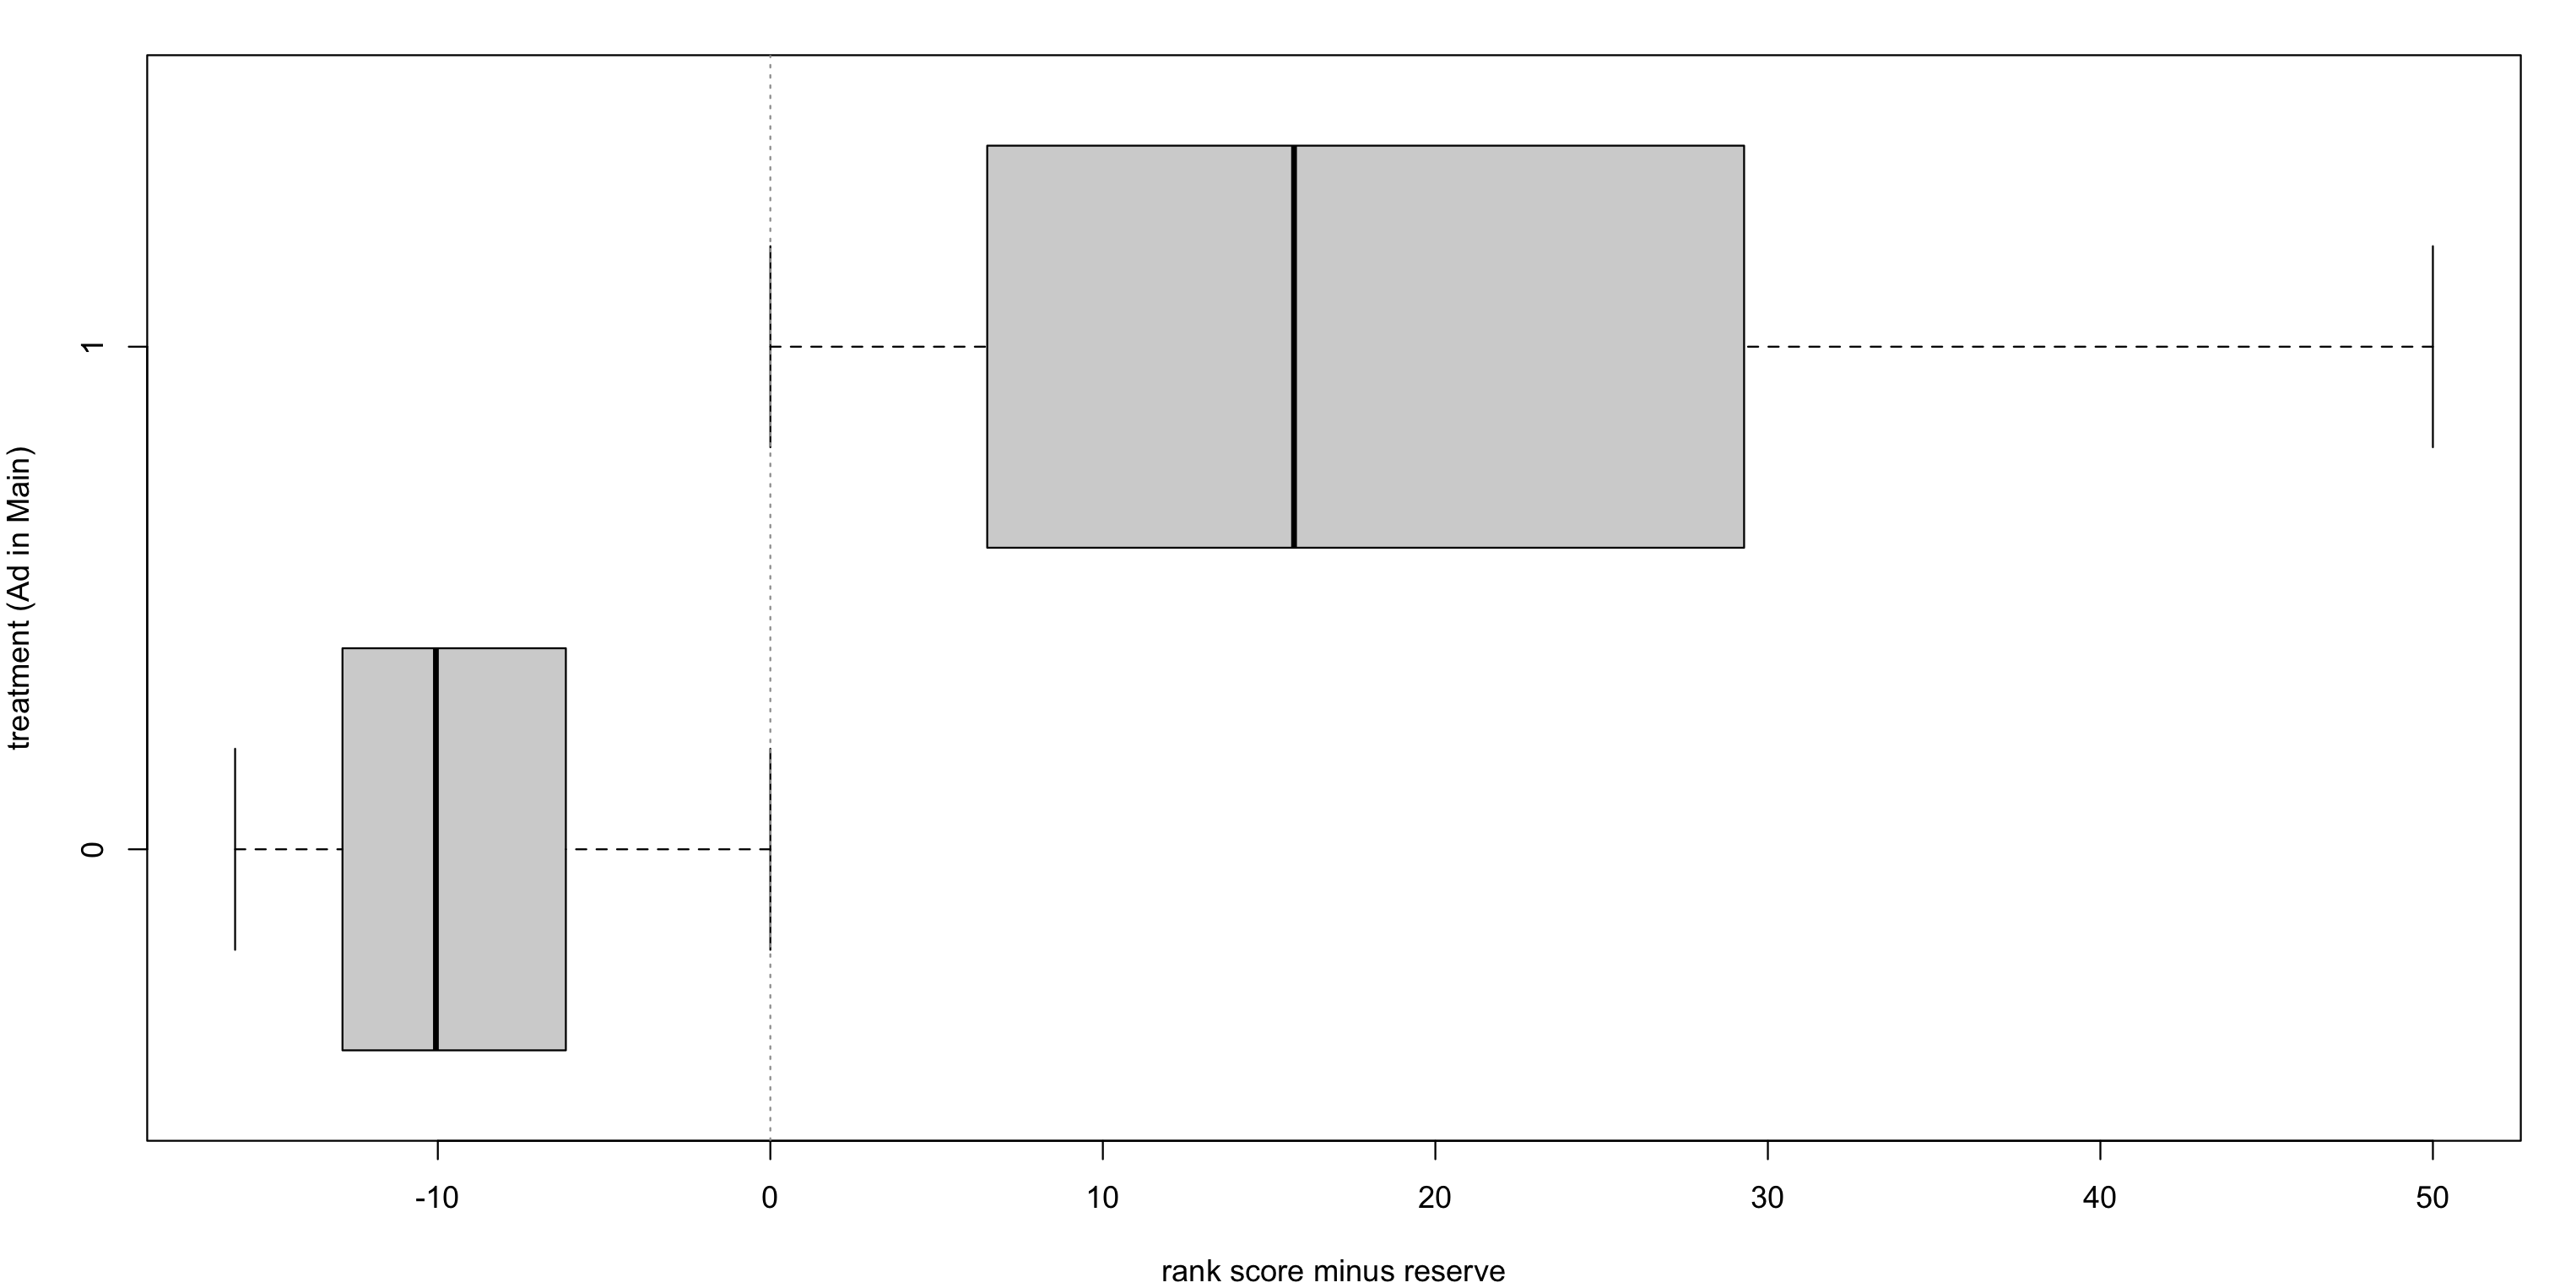

In [50]:
par(mai=c(.8,.8,.3,.3))
boxplot(score ~ treat, data=D, horizontal=TRUE, 
	xlab="rank score minus reserve",
 	ylab="treatment (Ad in Main)")
abline(v=0, col=8, lty=3)

Focus on a neighborhood:

In [51]:
w <- 3
above <- which(D$score > 0 & D$score <w)
below <- which(D$score < 0 & D$score >-w)

A constant model can simply compare the averages on both sides:

In [52]:
mua <- mean(D$y[above])
mub <- mean(D$y[below])
(te <- mua - mub)
vara <- var(D$y[above])
varb <- var(D$y[below])
sdte <- sqrt(vara/length(above) + varb/length(below))
te + c(-2,2)*sdte

[1] 0.01484979

[1] 0.01305012 0.01664947

Weighted least squares:

In [53]:
fita <- loess(y ~ score, data=D[above,], degree=1)
fitb <- loess(y ~ score, data=D[below,], degree=1)
rr <- seq(0.001,w-0.001,length=100)
preda <- predict(fita,rr) 
predb <- predict(fitb,-rr)

Local linear regression:

In [54]:
h <- 3
window <- which(D$score > -h & D$score < h)
summary(linfit <- lm(y ~ treat*score, data=D, subset=window))


Call:
lm(formula = y ~ treat * score, data = D, subset = window)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09789 -0.06847 -0.03451  0.03188  1.20805 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0820048  0.0011768  69.682  < 2e-16 ***
treat       0.0119216  0.0017396   6.853  7.3e-12 ***
score       0.0006188  0.0006627   0.934     0.35    
treat:score 0.0007242  0.0010020   0.723     0.47    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1043 on 58414 degrees of freedom
Multiple R-squared:  0.00503,	Adjusted R-squared:  0.004978 
F-statistic: 98.43 on 3 and 58414 DF,  p-value: < 2.2e-16


Save the predictions for plotting:

In [55]:
nr <- 10
rgrid <- seq(0, h, length=nr)
dgrid <- data.frame(score=c(-rev(rgrid),rgrid), 
					treat=rep(c(0,1),each=nr))
linpred <- predict(linfit, newdata=dgrid)

Get a confidence interval for the estimated treatment effect:

In [56]:
library(AER)
( ate <- coef(linfit)["treat"] )
seate <- sqrt(vcovHC(linfit)["treat","treat"])
ate + c(-2,2)*seate

treat 
0.0119216

[1] 0.00834634 0.01549686

Figure 5.6:

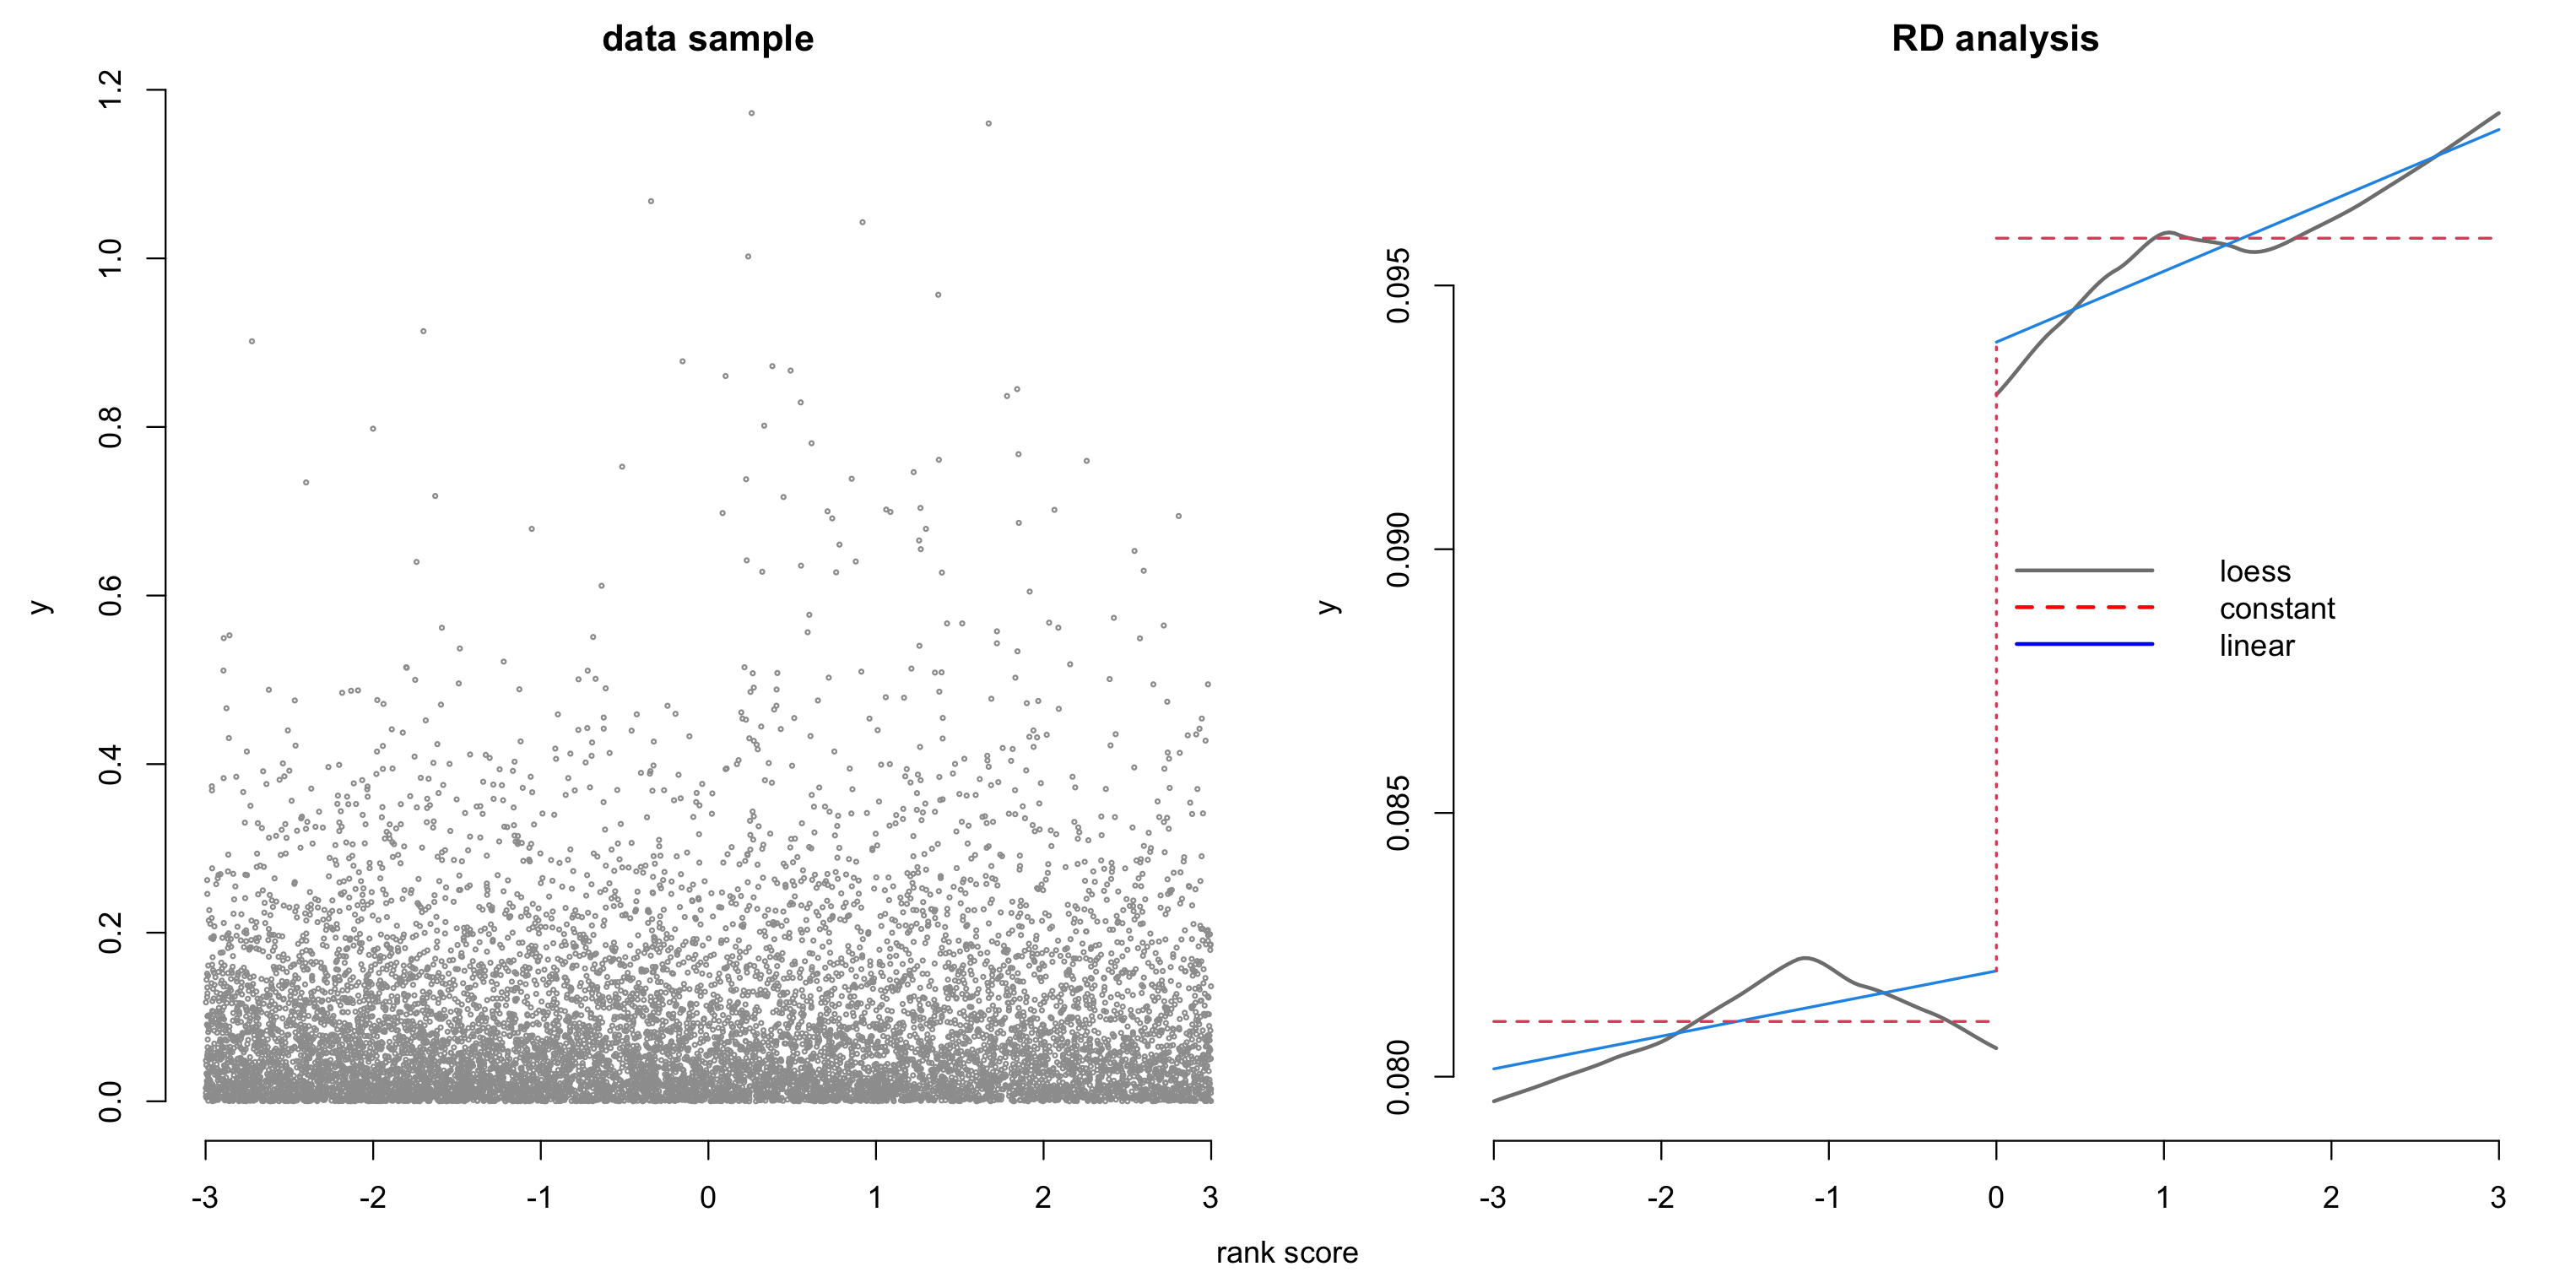

In [57]:
par(mfrow=c(1,2), omi=c(.5,0,0,0), mai=c(.3,.9,.4,.2))
plot(y ~ score, data=D, subset=sample(c(above,below),10000), 
		cex=.3, col=8, bty="n", xlab="", main="data sample")
plot(rr, preda, xlab="", col="grey50", ylab="y",lwd=2, 
	main="RD analysis",
	ylim=range(c(preda,predb)), xlim=c(-w,w), type="l", bty="n")
legend("right", bty="n", lwd=2, lty=c(1,2,1), col=c("grey50","red","blue"), 
	legend=c("loess","constant","linear"))
lines(-rr, predb, col="grey50", lwd=2)
lines(dgrid$score[1:nr], linpred[1:nr], lwd=1.5, col=4)
lines(dgrid$score[nr+1:nr], linpred[nr+1:nr], lwd=1.5, col=4)
lines(dgrid$score[1:nr], rep(mub,nr), lwd=1.5, lty=2, col=2)
lines(dgrid$score[nr+1:nr], rep(mua,nr), lwd=1.5, lty=2, col=2)
lines(c(0,0),coef(linfit)[1] + c(0,coef(linfit)[2]), lwd=1.5, col=2, lty=3)
mtext(side=1, "rank score", outer=TRUE, line=1)

We should be curious how the estimate changes with the chosen bandwidth. So let's reproduce Figure 5.7:

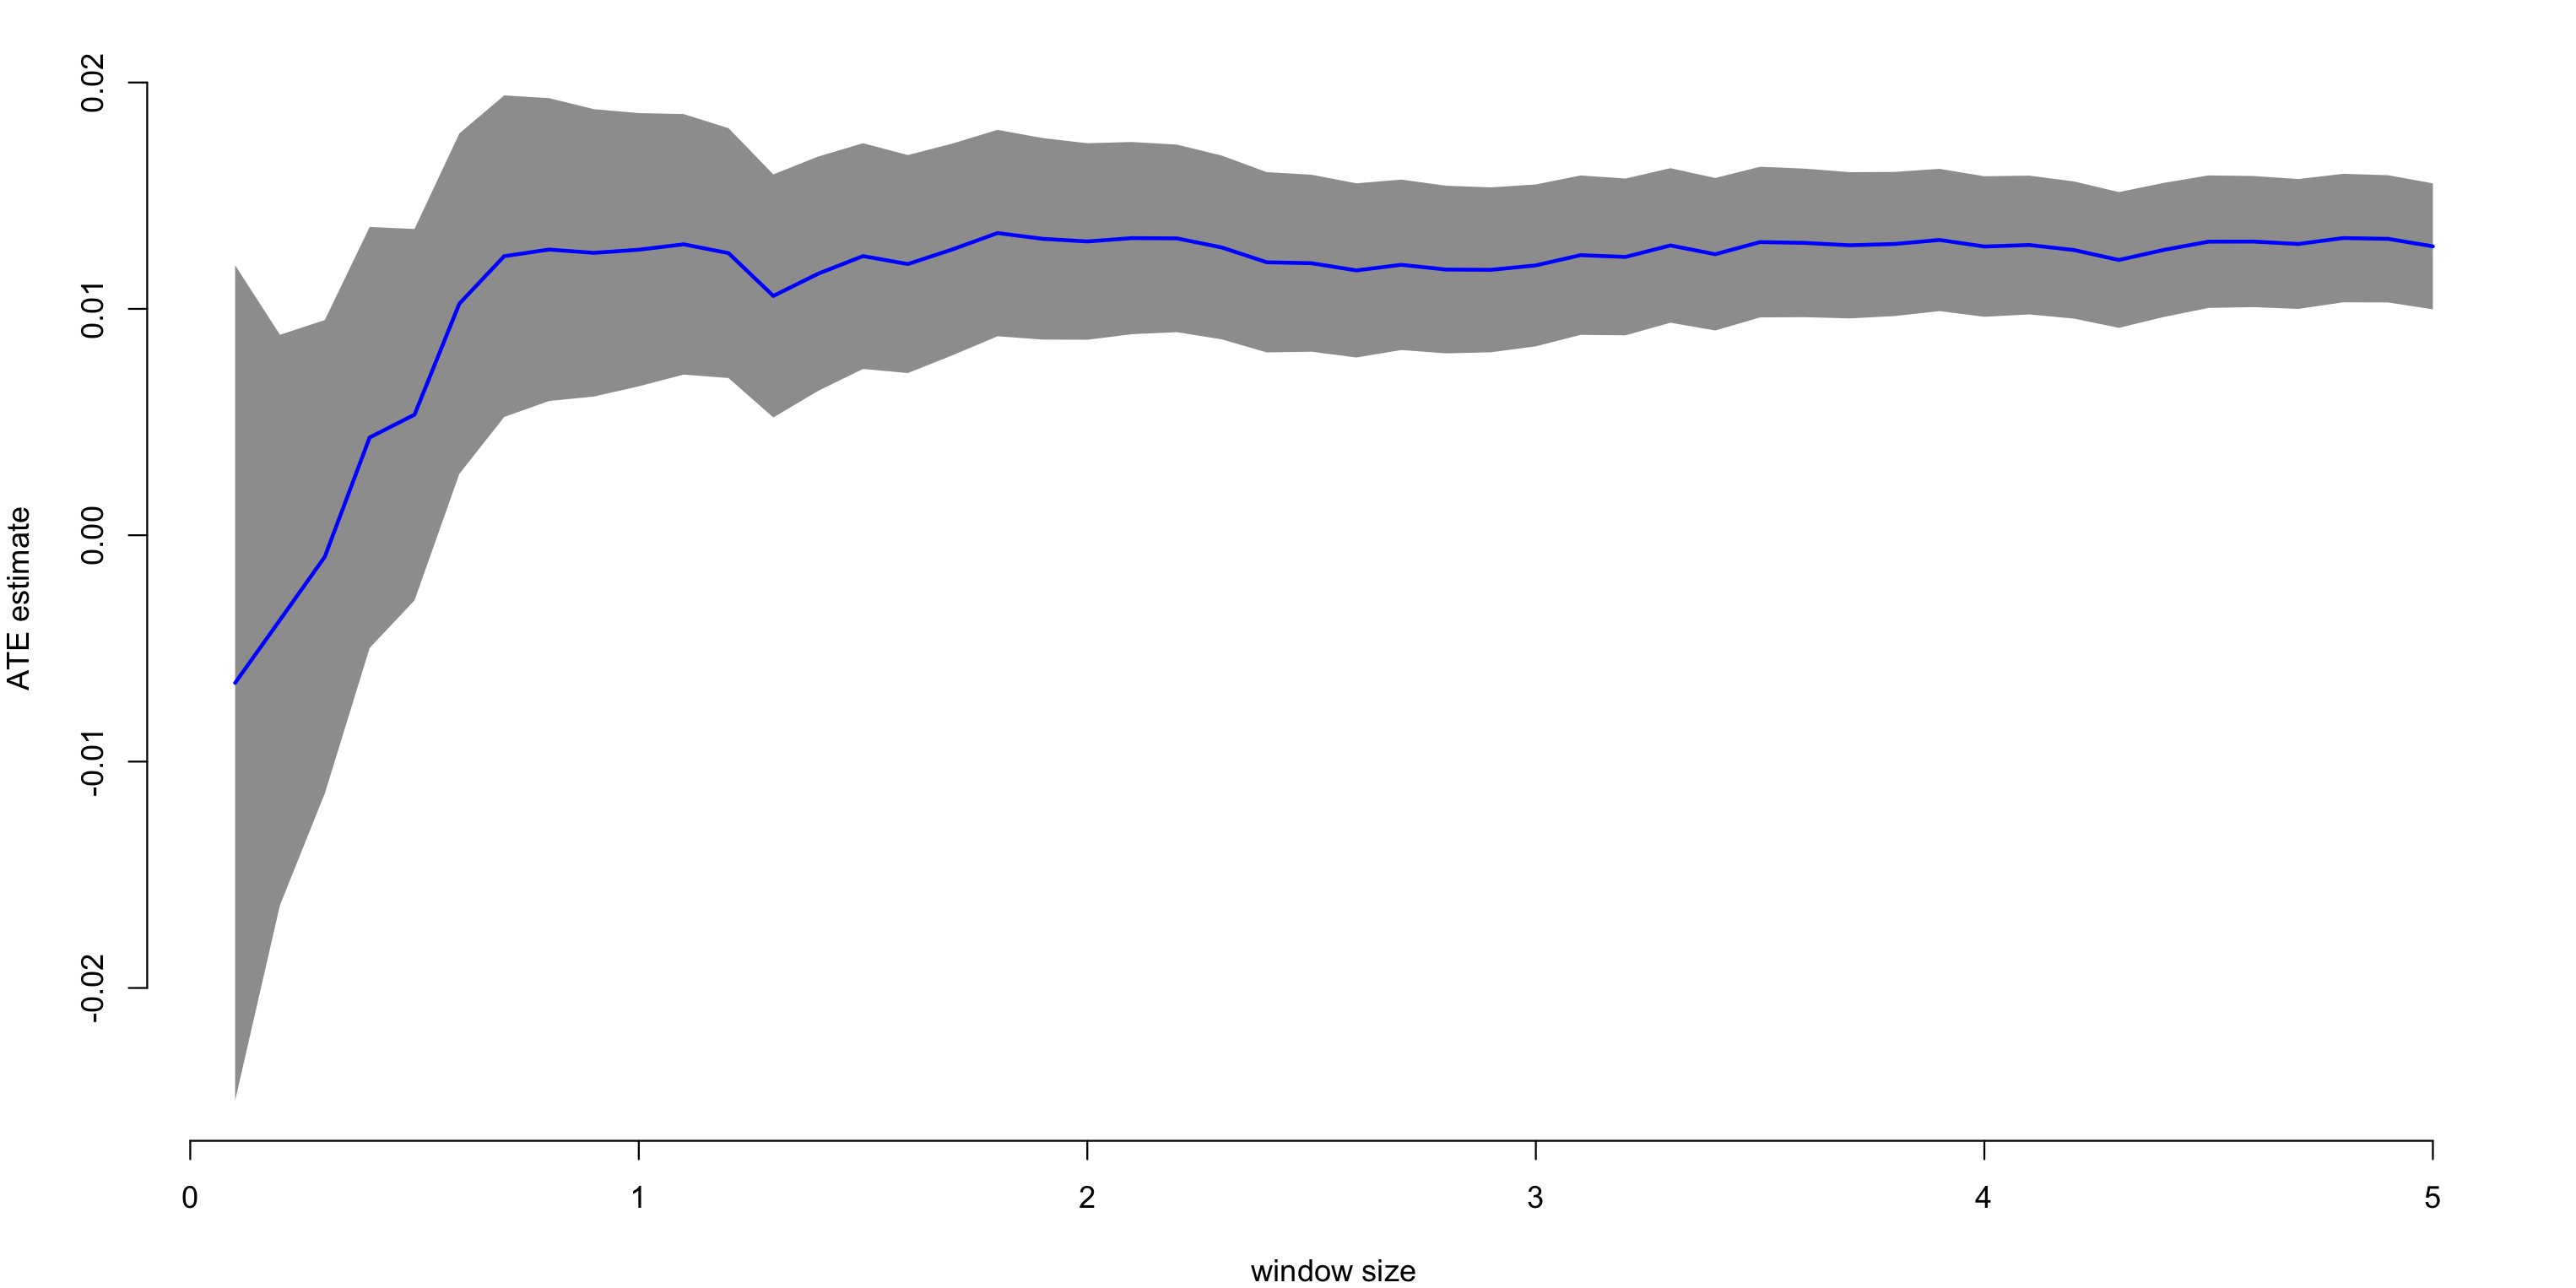

In [58]:
hh <- seq(.1,5,length=50)
ateh <- seah <- rep(0,length(hh))
for(i in 1:length(hh)){
#	print(i)
	fith <- lm(y ~ treat*score, data=D, 
		subset=which(abs(D$score) < hh[i]))
	ateh[i] <- coef(fith)[2]
	seah[i] <- sqrt(vcovHC(fith)[2,2])
}

up <- ateh+2*seah
down <- ateh-2*seah


par(mai=c(.8,.8,.3,.3))

plot(hh, ateh, type="l", ylim=range(c(up,down)), 
	xlab="window size", ylab="ATE estimate", bty="n")
polygon(c(hh,rev(hh)), c(up,rev(down)), col=8, border=FALSE)
lines(hh, ateh, col="blue", lwd=2)